# Project 3
## Instructions

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

Source: Natural Language Processing with Python, exercise 6.10.2.

This is NOT a team project as it was stated before.


### 1. Import the Names Corpus

In [1]:
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
try:
    nltk.data.find('corpora/names')
except:
    nltk.download('names')

from nltk.corpus import names

### 2. Preparing our data
Starting by creating a list of sets where each set is (name, gender) and then turning it into a pandas dataframe

In [2]:
name_list = ([(name, 'male') for name in names.words('male.txt')] + [(name, 'female') for name in names.words('female.txt')])

names_df = pd.DataFrame(name_list, columns=['name','gender'])
names_df.head()

,name,gender
0,Aamir,male
1,Aaron,male
2,Abbey,male
3,Abbie,male
4,Abbot,male


Below we'll set up some functions to create creatures for our dataset

In [3]:
# Create a features that's the % of word that's vowels
def vowel_proportion(series: pd.Series) -> pd.Series:
    def _ratio(text):
        if not isinstance(text, str) or not text:
            return 0.0
        
        vowel_count = sum(1 for char in text.lower() if char in 'aeiou')
        
        return vowel_count / len(text)

    return series.apply(_ratio)

# Create a features that's the % of the first and last letter being a vowel
def first_last_letter(series: pd.Series) -> pd.Series:
    def _check_ends(text):
        if not isinstance(text, str) or not text:
            return 0.0
            
        text_lower = text.lower()
        vowels = 'aeiou'
        vowel_endpoints = 0
        
        # Check first letter (index 0)
        if len(text_lower) >= 1 and text_lower[0] in vowels:
            vowel_endpoints += 1
            
        # Check last letter (index -1), but only if length is > 1 
        # to avoid double-counting the single character
        if len(text_lower) > 1 and text_lower[-1] in vowels:
            vowel_endpoints += 1
            
        # Proportion is always out of 2 possible positions
        return vowel_endpoints / 2.0

    return series.apply(_check_ends)

# Return an integer of the longest number of vowels in a name
def longest_run_of_vowels(series: pd.Series) -> pd.Series:
    def _max_run(text):
        if not isinstance(text, str):
            return 0
        
        text_lower = text.lower()
        vowels = 'aeiou'
        max_run = 0
        current_run = 0
        
        for char in text_lower:
            if char in vowels:
                current_run += 1
            else:
                # Vowel run is broken, check if it was the longest
                max_run = max(max_run, current_run)
                current_run = 0
                
        # Final check in case the string ends with a vowel run
        return max(max_run, current_run)

    return series.apply(_max_run)

def get_two_last_letters(series: pd.Series) -> pd.Series:
    def _last_letter(text):
        if not isinstance(text, str) or not text:
            return ''
        return text[-2:].lower()
    return series.apply(_last_letter)

In [4]:
def get_gender_features(df: pd.DataFrame) -> pd.DataFrame:
    funciton_list = [
        vowel_proportion,
        first_last_letter,
        longest_run_of_vowels,
        get_two_last_letters
    ]

    # Iterate through each function and apply them to the dataset
    for func in funciton_list:
        feature_name = func.__name__
        df[feature_name] = func(df['name'])
    
    return df

feature_names_df = get_gender_features(names_df)

print(names_df.value_counts('gender'))

names_df.head()

gender
female    5001
male      2943
Name: count, dtype: int64


,name,gender,vowel_proportion,first_last_letter,longest_run_of_vowels,get_two_last_letters
0,Aamir,male,0.6,0.5,2,ir
1,Aaron,male,0.6,0.5,2,on
2,Abbey,male,0.4,0.5,1,ey
3,Abbie,male,0.6,1.0,2,ie
4,Abbot,male,0.4,0.5,1,ot


From the above, we can see our dataset is fairly unbalanced with females making about 62% of the names.

For these numeric fields, we'll create histograms to visualize their distributions and color them based on gender.

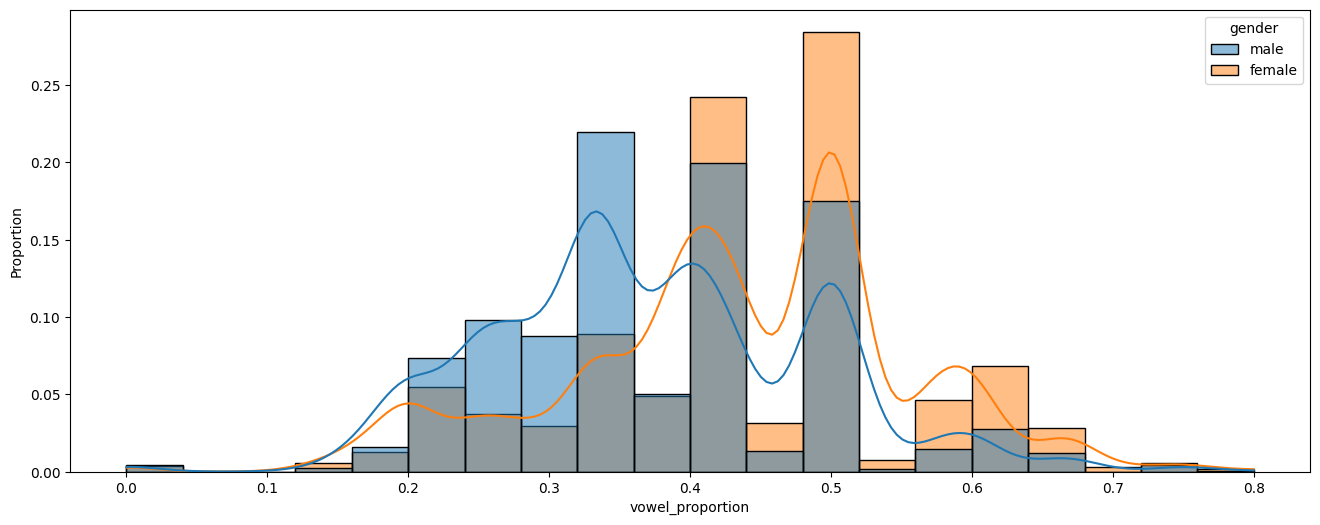

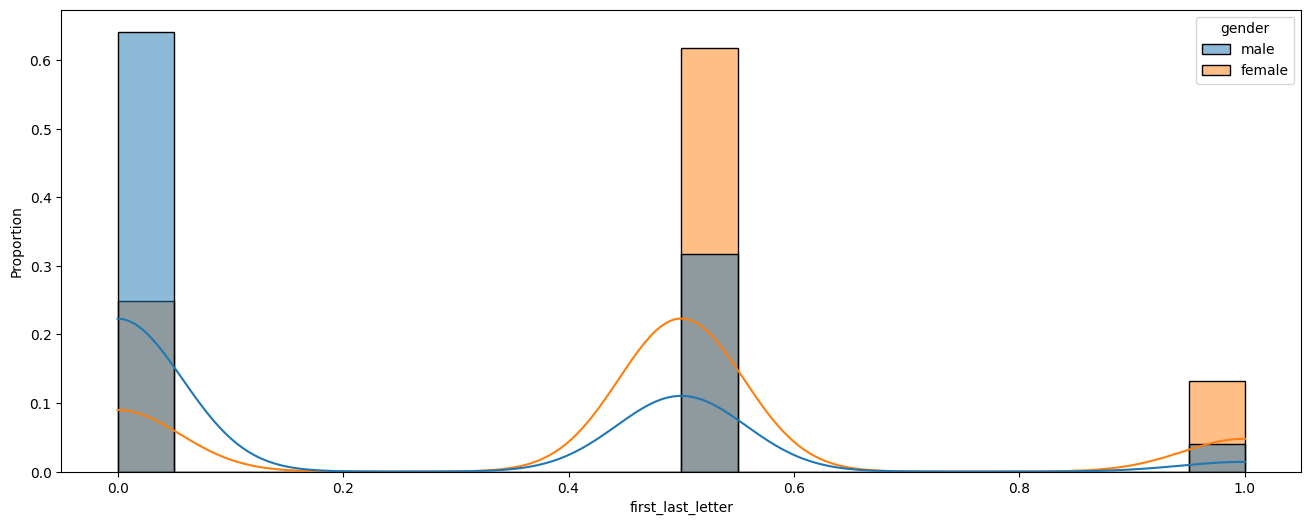

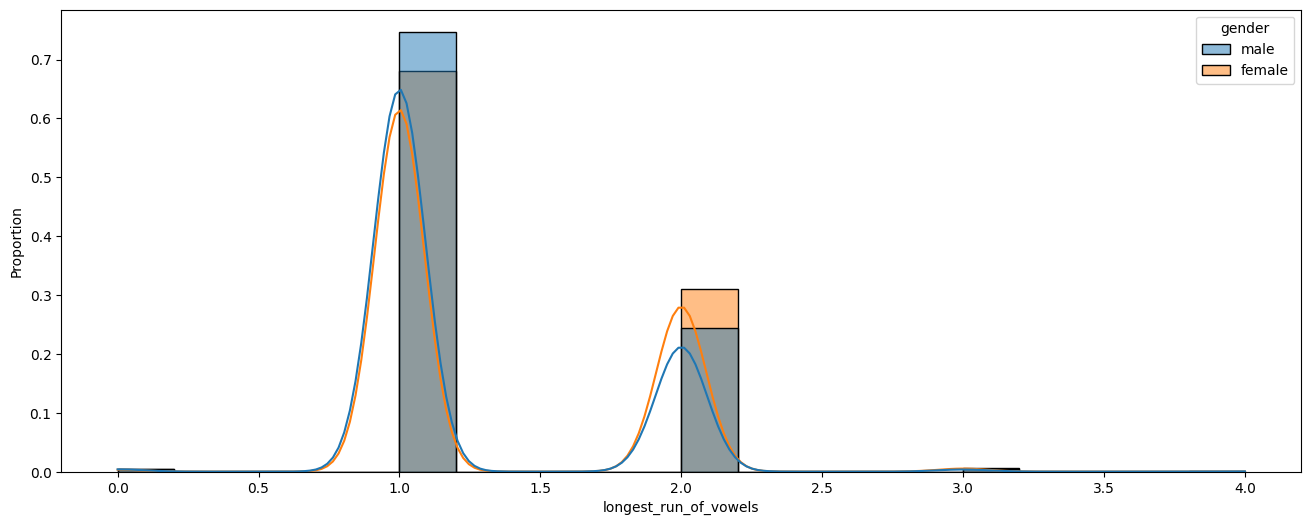

In [5]:
for num_col in names_df.columns:
    if names_df[num_col].dtype in ['int64', 'float64']:
        plt.figure(figsize=(16, 6))
        
        sns.histplot(
            data=names_df,
            x=num_col,
            hue='gender',
            stat="proportion",
            multiple='layer',
            kde=True,
            alpha=0.5,
            bins=20,
            common_norm=False
        )

        plt.show()

From our above histograms we can see that there is a slight difference in the distributions of vowel proportions and in the first and last letter. Although the longest run of vowels does not seem to differ much between genders.

Additionally, we've gotten the last 2 letters categorical features for our model.

### 3. Splitting our data

For our project, we'll split our data into a training and test dataset and balance the data so that there are equal numbers of male and female names

In [6]:
def split_data_for_nltk(names_df):
    # I turned this into a function because we're going to be doing this more and more
    x = names_df.drop('gender', axis=1)
    y = names_df['gender']

    x_train, x_test, y_train, y_test = train_test_split(
        x, 
        y, 
        test_size=0.2, 
        random_state=1, 
        stratify=y
    )

    # Print a summary of the split data
    print("\n--- Distribution after Stratified Split (80/20) ---")
    print("Training set (X_train, y_train) size:", len(y_train))
    print("Test set (X_test, y_test) size:", len(y_test))
    print("Training set counts:", Counter(y_train))
    print("Test set counts:", Counter(y_test))

    rus = RandomUnderSampler(random_state=1)

    # Apply the sampling only to the training set
    x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)

    # Print a summary of the final data
    print("\n--- Distribution after Undersampling Training Set ---")
    print("New (Balanced) Training set counts:", Counter(y_train_resampled))
    print(f"Total balanced training samples: {len(y_train_resampled)}")
    print("\nTest set (Unmodified for evaluation):")
    print("Test set counts:", Counter(y_test))
    return x_train_resampled, x_test, y_train_resampled, y_test

x_train_resampled, x_test, y_train_resampled, y_test = split_data_for_nltk(names_df)


--- Distribution after Stratified Split (80/20) ---
Training set (X_train, y_train) size: 6355
Test set (X_test, y_test) size: 1589
Training set counts: Counter({'female': 4001, 'male': 2354})
Test set counts: Counter({'female': 1000, 'male': 589})

--- Distribution after Undersampling Training Set ---
New (Balanced) Training set counts: Counter({'female': 2354, 'male': 2354})
Total balanced training samples: 4708

Test set (Unmodified for evaluation):
Test set counts: Counter({'female': 1000, 'male': 589})


With our datasets prepared, we'll need to convert it into the format expected by NLTK classifiers, which is a list of tuples where each tuple is (feature_dict, label)

In [7]:
def prepare_data_for_nltk(X_df, y_series):
    """Converts Pandas DataFrame/Series to NLTK's required list of (dict, label) tuples."""
    # Convert feature rows into a list of feature dictionaries
    feature_dicts = X_df.to_dict(orient='records')
    # Zip the feature dictionaries with the corresponding labels
    nltk_set = list(zip(feature_dicts, y_series))
    return nltk_set

train_nltk_data = prepare_data_for_nltk(x_train_resampled, y_train_resampled)
test_nltk_data = prepare_data_for_nltk(x_test, y_test)

### 4. Building our models
We'll try a few different models including:
1. NaiveBayesClassifier
2. DecisionTreeClassifier
3. MaxentClassifier

In [8]:
def train_nltk_classifiers(training_data):
    # I turned this into a function since we'll be iterating
    return(
        {
            'NaiveBayes': nltk.NaiveBayesClassifier.train(training_data),
            'DecisionTree': nltk.DecisionTreeClassifier.train(training_data),
            'MaxentClassifier': nltk.MaxentClassifier.train(training_data, max_iter=10, trace=0)
        }
    )

first_round_bathroom_classifiers = train_nltk_classifiers(train_nltk_data)

for name, classifier in first_round_bathroom_classifiers.items():
    accuracy = nltk.classify.accuracy(classifier, test_nltk_data)
    print(f"{name} Accuracy: {accuracy:.4f}")

NaiveBayes Accuracy: 0.7546
DecisionTree Accuracy: 0.3474
MaxentClassifier Accuracy: 0.7514


On the first round of models with our feature we find that the NaiveBayes classifier is the best performing with an accuracy of 76%.

In [9]:
first_round_bathroom_classifiers['NaiveBayes'].show_most_informative_features(20)

Most Informative Features
    get_two_last_letters = 'na'           female : male   =     81.4 : 1.0
    get_two_last_letters = 'la'           female : male   =     60.3 : 1.0
    get_two_last_letters = 'ia'           female : male   =     44.2 : 1.0
    get_two_last_letters = 'ra'           female : male   =     32.2 : 1.0
    get_two_last_letters = 'sa'           female : male   =     31.7 : 1.0
    get_two_last_letters = 'ta'           female : male   =     21.0 : 1.0
    get_two_last_letters = 'rt'             male : female =     17.0 : 1.0
    get_two_last_letters = 'ka'           female : male   =     16.3 : 1.0
    get_two_last_letters = 'us'             male : female =     14.7 : 1.0
    get_two_last_letters = 'ch'             male : female =     13.7 : 1.0
    get_two_last_letters = 'as'             male : female =     12.6 : 1.0
    get_two_last_letters = 'ld'             male : female =     11.8 : 1.0
    get_two_last_letters = 'ea'           female : male   =     11.7 : 1.0

Looking at the most important 20 features we can see that they're all related to the last two letters of the name. Extending the importance further, we found that a vowel proportion of 55.5% was the first non-last-two-letters feature to appear in the list.

To further improve our model, we can likely engineer more features related to the letters in the names.

### 5. Iteration 1 for new features
First we saw taht the numeric columns we assumed might be useful weren't very informative and thus decided to drop them from our feature set.

In [12]:
names_df = names_df.drop(columns = ['vowel_proportion', 'first_last_letter', 'longest_run_of_vowels'], errors='ignore')
names_df.head()

,name,gender,get_two_last_letters,name_length,first_letter
0,Aamir,male,ir,5,a
1,Aaron,male,on,5,a
2,Abbey,male,ey,5,a
3,Abbie,male,ie,5,a
4,Abbot,male,ot,5,a


For a new set of features, we'll use the first letter of the word and we'll also add in the length of the name as a feature. For the new numeric value, we'll also plot a histogram as we did before.

In [13]:
names_df['name_length'] = names_df['name'].apply(len)
names_df['first_letter'] = names_df['name'].str[0].str.lower()
names_df.head()

,name,gender,get_two_last_letters,name_length,first_letter
0,Aamir,male,ir,5,a
1,Aaron,male,on,5,a
2,Abbey,male,ey,5,a
3,Abbie,male,ie,5,a
4,Abbot,male,ot,5,a


<Axes: xlabel='name_length', ylabel='Proportion'>

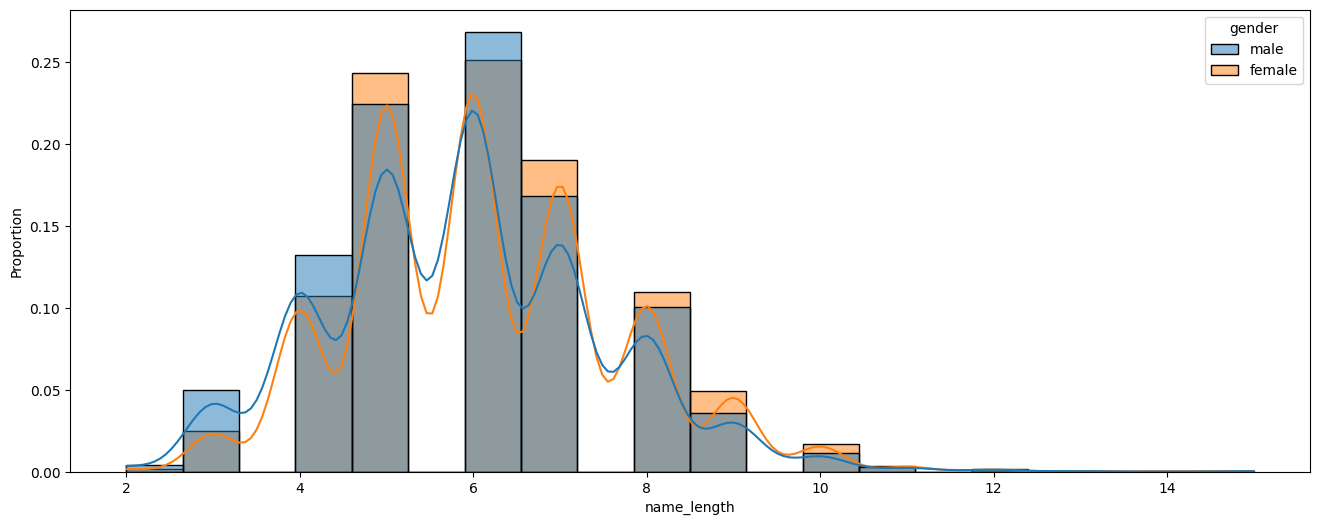

In [14]:
plt.figure(figsize=(16, 6))

sns.histplot(
    data=names_df,
    x='name_length',
    hue='gender',
    stat="proportion",
    multiple='layer',
    kde=True,
    alpha=0.5,
    bins=20,
    common_norm=False
)

Name length doesn't seem to provide any information so we'll drop it from our dataset

In [15]:
names_df = names_df.drop(columns=['name_length'], errors='ignore')
names_df.head()

,name,gender,get_two_last_letters,first_letter
0,Aamir,male,ir,a
1,Aaron,male,on,a
2,Abbey,male,ey,a
3,Abbie,male,ie,a
4,Abbot,male,ot,a


In the spirit of trying something new, let's get the longest constanant chain

In [16]:
def gimme_the_longest_constanant_chain(name: pd.Series) -> pd.Series:
    if not isinstance(name, str):
        return '' # Return empty string for non-string input
    
    consonants = set('bcdfghjklmnpqrstvwxyz')
    name_lower = name.lower()
    
    max_chain_str = ""
    current_chain_str = ""
    
    for char in name_lower:
        if char.isalpha() and char in consonants:
            # Character is a consonant, append it to the current chain string
            current_chain_str += char
        else:
            # Character is a vowel, 'y', or non-alphabetic
            # Check if the current chain is the longest found so far
            if len(current_chain_str) > len(max_chain_str):
                max_chain_str = current_chain_str
            # Reset the current chain string
            current_chain_str = ""
            
    # Important: Check one last time after the loop finishes 
    # (in case the longest chain ends the string)
    if len(current_chain_str) > len(max_chain_str):
        max_chain_str = current_chain_str

    return max_chain_str

names_df['longest_constanant_chain'] = names_df['name'].apply(gimme_the_longest_constanant_chain)
names_df.head()

,name,gender,get_two_last_letters,first_letter,longest_constanant_chain
0,Aamir,male,ir,a,m
1,Aaron,male,on,a,r
2,Abbey,male,ey,a,bb
3,Abbie,male,ie,a,bb
4,Abbot,male,ot,a,bb


With these new features, we'll try these into the classifiers again and see how they perform.

In [18]:
# We'll define a new function to just pass the dataframe and do all of the previous steps
def dataframe_to_classifiers(names_df, training_cycle_name):
    x_train_resampled, x_test, y_train_resampled, y_test = split_data_for_nltk(names_df)
    train_nltk_data = prepare_data_for_nltk(x_train_resampled, y_train_resampled)
    test_nltk_data = prepare_data_for_nltk(x_test, y_test)

    train_nltk_classifiers(train_nltk_data)
    
    print(f"\n--- Results for {training_cycle_name} ---")

    best_classifier = None

    for name, classifier in first_round_bathroom_classifiers.items():
        accuracy = nltk.classify.accuracy(classifier, test_nltk_data)

        if best_classifier is None:
            best_classifier = classifier
        else:
            if accuracy > nltk.classify.accuracy(best_classifier, test_nltk_data):
                best_classifier = classifier

        print(f"{name} Accuracy: {accuracy:.4f}")
    
    print(f"\nThe best classifier is {best_classifier.__class__.__name__} with an accuracy of {nltk.classify.accuracy(best_classifier, test_nltk_data):.4f}\n")

    best_classifier.show_most_informative_features(20)

dataframe_to_classifiers(names_df, "Last Two Letters, First Letter, & Longest Consonant Chain")



--- Distribution after Stratified Split (80/20) ---
Training set (X_train, y_train) size: 6355
Test set (X_test, y_test) size: 1589
Training set counts: Counter({'female': 4001, 'male': 2354})
Test set counts: Counter({'female': 1000, 'male': 589})

--- Distribution after Undersampling Training Set ---
New (Balanced) Training set counts: Counter({'female': 2354, 'male': 2354})
Total balanced training samples: 4708

Test set (Unmodified for evaluation):
Test set counts: Counter({'female': 1000, 'male': 589})



--- Results for Last Two Letters, First Letter, & Longest Consonant Chain ---
NaiveBayes Accuracy: 0.7520
DecisionTree Accuracy: 0.3474
MaxentClassifier Accuracy: 0.7577

The best classifier is MaxentClassifier with an accuracy of 0.7577

  -5.294 get_two_last_letters=='na' and label is 'male'
  -5.129 get_two_last_letters=='la' and label is 'male'
  -4.397 get_two_last_letters=='ia' and label is 'male'
   4.341 name=='Dana' and label is 'male'
   4.247 name=='Bela' and label is 'male'
  -4.224 get_two_last_letters=='sa' and label is 'male'
   4.218 name=='Isa' and label is 'male'
  -4.080 get_two_last_letters=='ra' and label is 'male'
   3.881 name=='Krishna' and label is 'male'
   3.824 name=='Ezra' and label is 'male'
   3.770 name=='Garcia' and label is 'male'
   3.603 name=='Gert' and label is 'female'
   3.320 name=='Ragnhild' and label is 'female'
  -3.316 get_two_last_letters=='ka' and label is 'male'
  -3.307 get_two_last_letters=='ta' and label is 'male'
   3.209 name=='Mika

This model performed about the same as our first model with a very minor improvement. 